In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'torch'
import keras
print(f"Keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")

Keras version: 3.10.0
Using backend: torch


In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("Training will be significantly faster on GPU!")
else:
    device = torch.device("cpu")
    print("No GPU detected - using CPU")
    print("Training will be slower. Consider using Google Colab or Kaggle Kernel for free GPU access.")

GPU available: Tesla T4
Memory: 15.83 GB
Training will be significantly faster on GPU!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from collections import Counter

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
ratings = pd.read_csv('ratings.csv')
ratings.nunique()

,0
userId,610
movieId,9724
rating,10
timestamp,85043


In [ ]:
n_users = int(ratings.nunique()['userId'])
n_movies = int(ratings.nunique()['movieId'])

In [ ]:
unique_movie_ids = ratings['movieId'].unique()
movie_idx = {mid:idx+1 for idx, mid in enumerate(unique_movie_ids)}

In [ ]:
ratings['movieId'] = ratings['movieId'].map(movie_idx)
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s', utc=True)
ratings = ratings.sort_values(by = ['userId', 'timestamp'], ascending=[True, True])

In [ ]:
user_sequences = ratings.groupby('userId')['movieId'].apply(list).to_dict()

## **Milestone Model**
No dropout, early stopping, or context

In [ ]:
look_back = 12

train_X, train_y = [], []
val_X, val_y = [], []
test_X, test_y = [], []

for u, seq in user_sequences.items():

    train_seq = seq[:-2]
    val_item  = seq[-2]
    test_item = seq[-1]

    # Training windows
    for i in range(len(train_seq) - look_back):
        window = train_seq[i:i+look_back]
        target = train_seq[i+look_back]
        train_X.append(window)
        train_y.append(target)

    # Validation window
    val_window = train_seq[-look_back:]
    val_X.append(val_window)
    val_y.append(val_item)

    # Test window
    test_window = seq[:-1][-look_back:]
    test_X.append(test_window)
    test_y.append(test_item)

train_X = np.array(train_X, dtype=np.int32)
train_y = np.array(train_y, dtype=np.int32)
val_X   = np.array(val_X,   dtype=np.int32)
val_y   = np.array(val_y,   dtype=np.int32)
test_X  = np.array(test_X,  dtype=np.int32)
test_y  = np.array(test_y,  dtype=np.int32)

print("Train:", train_X.shape)
print("Validation:", val_X.shape)
print("Test:", test_y.shape)


Train: (92296, 12)
Validation: (610, 12)
Test: (610,)


In [ ]:
num_movies = ratings['movieId'].nunique()
vocab_size = num_movies + 1  # padding index 0

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_shape=(look_back,), mask_zero=True),
    LSTM(256, name='lstm'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(vocab_size, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy',
                       tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5'),
                       tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top10')])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 12, 128)        │     1,244,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9725)           │     1,254,525 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,189,373 (12.17 MB)

 Trainable params: 3,189,373 (12.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x=train_X, y=train_y, batch_size=256, epochs=30, validation_data=(val_X, val_y), verbose=1)

Epoch 1/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 8.4180 - sparse_categorical_accuracy: 0.0021 - top10: 0.0166 - top5: 0.0090 - val_loss: 8.0745 - val_sparse_categorical_accuracy: 0.0000e+00 - val_top10: 0.0197 - val_top5: 0.0131
Epoch 2/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 7.9427 - sparse_categorical_accuracy: 0.0021 - top10: 0.0198 - top5: 0.0104 - val_loss: 8.0322 - val_sparse_categorical_accuracy: 0.0033 - val_top10: 0.0361 - val_top5: 0.0164
Epoch 3/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 7.7595 - sparse_categorical_accuracy: 0.0030 - top10: 0.0269 - top5: 0.0144 - val_loss: 7.8915 - val_sparse_categorical_accuracy: 0.0016 - val_top10: 0.0213 - val_top5: 0.0164
Epoch 4/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 7.4951 - sparse_categorical_accuracy: 0.0033 - top10: 0.0347 - top5: 0.0172 - val_loss: 7.6946 - val_sparse_categorical_accuracy: 0.0016 - val_top10: 0.0410 - val_top5: 0.0213
Epoch 5/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 14s 

In [ ]:
result = model.evaluate(test_X, test_y, batch_size=256)
print('Loss:', result[0])
print('Top-1 Accuracy:', round(result[1]*100, 4), '%')
print('Top-5 Accuracy:', round(result[2]*100, 4), '%')
print('Top-10 Accuracy:', round(result[3]*100, 4), '%')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.6356 - sparse_categorical_accuracy: 0.0043 - top10: 0.0496 - top5: 0.0268    
Loss: 11.7067289352417
Top-1 Accuracy: 0.6557 %
Top-5 Accuracy: 2.623 %
Top-10 Accuracy: 4.7541 %


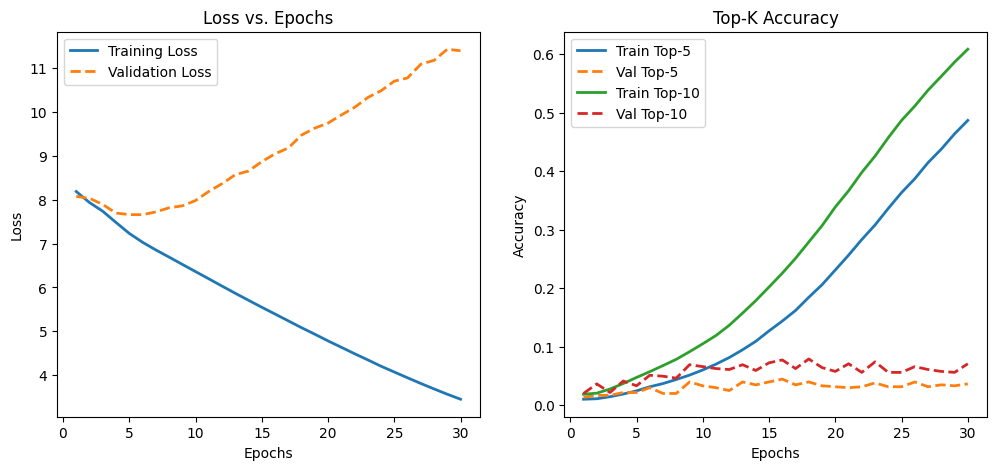

In [ ]:
def plot_training_metrics(history):
    history_dict = history.history
    epochs = range(1, len(history_dict['loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['loss'], label='Training Loss', linewidth=2)
    plt.plot(epochs, history_dict['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Top-5 and Top-10 Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict['top5'], label='Train Top-5', linewidth=2)
    plt.plot(epochs, history_dict['val_top5'], label='Val Top-5', linestyle='--', linewidth=2)
    plt.plot(epochs, history_dict['top10'], label='Train Top-10', linewidth=2)
    plt.plot(epochs, history_dict['val_top10'], label='Val Top-10', linestyle='--', linewidth=2)
    plt.title('Top-K Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_metrics(history)


# **Evaluation**

## **Item Pop**
Items are ranked by their popularity judged by the number of interactions.

In [ ]:
def item_pop_baseline(train_X, train_y, test_y, k_values=[5, 10]):

    all_train_movies = np.concatenate([train_X.flatten(), train_y])
    all_train_movies = all_train_movies[all_train_movies != 0]     # No padding

    movie_counts = Counter(all_train_movies)
    top_movies = [m for m, c in movie_counts.most_common(max(k_values))]

    results = {}
    for k in k_values:
        top_k_set = set(top_movies[:k])
        freq = 0
        for target in test_y:
            if target in top_k_set:
                freq += 1

        accuracy = freq / len(test_y)
        results[k] = accuracy
        print(f"ItemPop Top-{k} Accuracy: {round(accuracy*100,4)}%")

    return results


baseline_results = item_pop_baseline(train_X, train_y, test_y)

ItemPop Top-5 Accuracy: 1.1475%
ItemPop Top-10 Accuracy: 2.623%


## **Negative Sampling**

### ItemPop

In [ ]:
def item_pop_sampled(X_train, y_train, X_test, y_test, k_values=range(1,11), num_negatives=100):

    random.seed(3) # Reproducibility

    train_movie_ids = X_train.flatten()
    all_train_movies = np.concatenate([train_movie_ids, y_train])
    all_train_movies = all_train_movies[all_train_movies != 0]

    counts = Counter(all_train_movies)
    unique_train_movies = np.array(list(counts.keys()))

    freqs = {k: 0 for k in k_values}
    num_users = len(y_test)

    for i in range(num_users):
        target_item = y_test[i]
        user_history_set = set(X_test[i])
        user_history_set.add(target_item)

        # Negative sampling
        negatives = set()
        while len(negatives) < num_negatives:
            neg_id = random.choice(unique_train_movies)
            if neg_id not in user_history_set:
                negatives.add(neg_id)

        candidates = [target_item] + list(negatives)
        scores = np.array([counts.get(movie_id, 0) for movie_id in candidates])
        ranked_indices = np.argsort(scores)[::-1]
        rank = np.where(ranked_indices == 0)[0][0] + 1 # Find the rank of target_item

        for k in k_values:
            if rank <= k:
                freqs[k] += 1

    results = {}
    for k in k_values:
        HR = round((freqs[k] / num_users) * 100, 2)
        results[k] = HR
        if k % 5 ==0:
          print(f"ItemPop Baseline HR@{k}: {HR}%")

    return results

item_pop_sampled_results = item_pop_sampled(train_X, train_y, test_X, test_y)

ItemPop Baseline HR@5: 40.66%
ItemPop Baseline HR@10: 57.87%


### Milestone Model

In [ ]:
def negative_sampling_baseline(model, X_test, y_test, k_values=range(1,11), num_negatives=100):

    random.seed(3)

    all_probs = model.predict(X_test, batch_size=256, verbose=0)
    freqs = {k: 0 for k in k_values}
    num_users = len(y_test)

    for i in range(num_users):
        target_item = y_test[i]
        user_history_set = set(X_test[i])
        user_history_set.add(target_item)

        # Negative sampling
        negatives = set()
        while len(negatives) < num_negatives:
            neg_id = random.randint(1, vocab_size-1)
            if neg_id not in user_history_set:
                negatives.add(neg_id)

        candidates = [target_item] + list(negatives)
        scores = all_probs[i][candidates]
        ranked_indices = np.argsort(scores)[::-1]
        rank = np.where(ranked_indices == 0)[0][0] + 1

        for k in k_values:
            if rank <= k:
                freqs[k] += 1

    results = {}
    for k in k_values:
        HR = round((freqs[k] / num_users)*100, 2)
        results[k] = HR
        if k % 5 == 0:
          print(f"Hit Ratio@{k}: {HR}%")

    return results

results_negative_sampled_baseline = negative_sampling_baseline(model, test_X, test_y)

Hit Ratio@5: 47.21%
Hit Ratio@10: 62.62%


# HR@K vs. K Visualization

In [ ]:
# HR@K results from the final model
results_negative_sampled_final = {1: 24.43,
                                  2: 34.59,
                                  3: 43.61,
                                  4: 50.66,
                                  5: 56.07,
                                  6: 59.84,
                                  7: 62.46,
                                  8: 65.25,
                                  9: 67.54,
                                  10: 69.51}

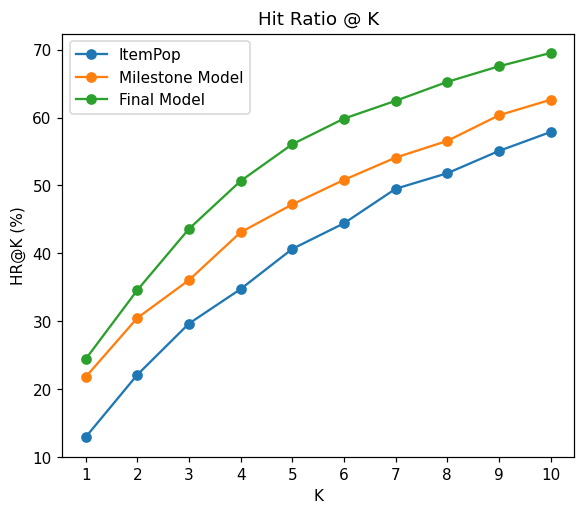

In [ ]:
HRs_item = [item_pop_sampled_results[k] for k in range(1,11)]
HRs_milestone = [results_negative_sampled_baseline[k] for k in range(1,11)]
HRs_final = [results_negative_sampled_final[k] for k in range(1,11)]

plt.figure(figsize=(6,5), dpi=110)
plt.plot(range(1,11), HRs_item, marker='o', label="ItemPop")
plt.plot(range(1,11), HRs_milestone, marker='o', label="Milestone Model")
plt.plot(range(1,11), HRs_final, marker='o', label="Final Model")

plt.xlabel("K")
plt.ylabel("HR@K (%)")
plt.title("Hit Ratio @ K")
plt.xticks(range(1,11))
plt.ylim(bottom=10)
plt.legend()
plt.show()
